Summary of calculation changes:
-  3004 institutions
- natives, outgoers, and newcomers are not longer overlapping sets of researchers
- weighted cosine seems better than normal cosine


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sun Jan 21 17:27:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Mounted at /content/drive
Authenticated


# Preprocessing

In [19]:
# @title Loading the datasets
import pandas as pd
import zipfile

column_names = [
    'researcher_id',
    'grid_id',
    'pub_year',
    'pubs',
    'cluster_id1',
    'LR_main_field_id',
    'LR_main_field',
    'native',
    'outgoer',
    'newcomer'
]

PATH = '/content/drive/My Drive/revisions_natcomms/data/raw_vector_df.zip'

with zipfile.ZipFile(PATH, 'r') as z:
    with z.open('raw_vector_df.csv') as f:
        df = pd.read_csv(f, sep = ';', header=None, names=column_names)

print(df.head(1))

print(df['LR_main_field'].unique())
print("Number of unique publication years:", df['pub_year'].nunique())
print("Number of unique clusters:", df['cluster_id1'].nunique())
print("Number of unique researchers:", df['researcher_id'].nunique())
print("Number of unique institutions:", df['grid_id'].nunique())

       researcher_id        grid_id  pub_year  pubs  cluster_id1  \
0  ur.01000000010.53  grid.461843.c      2011     1          533   

   LR_main_field_id                   LR_main_field  native  outgoer  newcomer  
0                 2  Biomedical and health sciences       0        1         0  
['Biomedical and health sciences' 'Physical sciences and engineering'
 'Life and earth sciences' 'Social sciences and humanities'
 'Mathematics and computer science']
Number of unique publication years: 43
Number of unique clusters: 4199
Number of unique researchers: 8839094
Number of unique institutions: 3004


In [20]:
# Create separate DataFrames for each category in 'LR_main_field'
import os

df_biomedical = df[df['LR_main_field'] == 'Biomedical and health sciences']
df_physical = df[df['LR_main_field'] == 'Physical sciences and engineering']
df_life_earth = df[df['LR_main_field'] == 'Life and earth sciences']
df_social = df[df['LR_main_field'] == 'Social sciences and humanities']
df_math_cs = df[df['LR_main_field'] == 'Mathematics and computer science']

dir_path = "/content/drive/My Drive/revisions_natcomms/data/"

df_biomedical.to_csv(dir_path + 'biomedical_and_health_sciences.csv', index=False)
df_physical.to_csv(dir_path + 'physical_sciences_and_engineering.csv', index=False)
df_life_earth.to_csv(dir_path + 'life_and_earth_sciences.csv', index=False)
df_social.to_csv(dir_path + 'social_sciences_and_humanities.csv', index=False)
df_math_cs.to_csv(dir_path + 'mathematics_and_computer_science.csv', index=False)

In [21]:
# Read the data back
import pandas as pd

dir_path = "/content/drive/My Drive/revisions_natcomms/data/"

biomedical_csv_path = dir_path + 'biomedical_and_health_sciences.csv'
physical_csv_path = dir_path + 'physical_sciences_and_engineering.csv'
life_earth_csv_path = dir_path + 'life_and_earth_sciences.csv'
social_csv_path = dir_path + 'social_sciences_and_humanities.csv'
math_cs_csv_path = dir_path + 'mathematics_and_computer_science.csv'

df_biomedical = pd.read_csv(biomedical_csv_path)
df_physical = pd.read_csv(physical_csv_path)
df_life_earth = pd.read_csv(life_earth_csv_path)
df_social = pd.read_csv(social_csv_path)
df_math_cs = pd.read_csv(math_cs_csv_path)

In [22]:
df_social.head(5)

,researcher_id,grid_id,pub_year,pubs,cluster_id1,LR_main_field_id,LR_main_field,native,outgoer,newcomer
0,ur.010000000761.51,grid.412304.0,2014,1,567,1,Social sciences and humanities,1,0,0
1,ur.01000000145.32,grid.411638.9,2020,1,1980,1,Social sciences and humanities,0,0,1
2,ur.010000002003.53,grid.12380.38,2013,1,737,1,Social sciences and humanities,1,0,0
3,ur.01000000410.68,grid.5841.8,2008,4,424,1,Social sciences and humanities,0,1,0
4,ur.01000000410.68,grid.5841.8,2009,1,424,1,Social sciences and humanities,0,1,0


In [25]:
def split_and_save(df, field_name, dir_path):

    columns_to_keep = {'researcher_id': 'aut', 'grid_id': 'ins', 'cluster_id1': 'topic', 'pubs': 'w'}

    for category in ['native', 'newcomer', 'outgoer', 'all']:
        if category == 'all':
            # For 'all'
            df_filtered = df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)
        else:
            # For specific categories
            df_filtered = df[df[category] == 1][list(columns_to_keep.keys())].rename(columns=columns_to_keep)

        file_name = f'df_{field_name}_{category}.csv'
        df_filtered.to_csv(dir_path + file_name, index=False)

split_and_save(df_biomedical, 'biomedical', dir_path)
split_and_save(df_physical, 'physical', dir_path)
split_and_save(df_life_earth, 'life_earth', dir_path)
split_and_save(df_social, 'social', dir_path)
split_and_save(df_math_cs, 'math_cs', dir_path)

In [ ]:
# @title nat vs out (binary cosine)
# GET AUTHOR-INSTITUTION COSINE FOR NATIVES AND OUTGOERS
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def load_df(file_path):
    df = pd.read_csv(file_path)
    return df

dir_path = "/content/drive/My Drive/revisions_natcomms/data/"

df_social_native = load_df(dir_path + 'df_social_native.csv')
df_social_outgoer = load_df(dir_path + 'df_social_outgoer.csv')

unique_skills_native = df_social_native['sk'].unique()
unique_skills_outgoer = df_social_outgoer['sk'].unique()
combined_skills = set(unique_skills_native) | set(unique_skills_outgoer)
global_unique_skills = list(combined_skills)

grouped_native = df_social_native.groupby('ins')['sk'].apply(list).reset_index()
grouped_outgoer = df_social_outgoer.groupby('ins')['sk'].apply(list).reset_index()

native_skill_dict = {row['ins']: row['sk'] for _, row in grouped_native.iterrows()}
outgoer_skill_dict = {row['ins']: row['sk'] for _, row in grouped_outgoer.iterrows()}

def compute_cosine_similarity(skill_vector1, skill_vector2):
    vector1 = np.zeros(len(global_unique_skills))
    vector2 = np.zeros(len(global_unique_skills))

    for skill_id in skill_vector1:
        idx = global_unique_skills.index(skill_id)
        vector1[idx] = 1

    for skill_id in skill_vector2:
        idx = global_unique_skills.index(skill_id)
        vector2[idx] = 1

    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity

cosine_similarities = {}

for institution in native_skill_dict.keys():
    native_skills = native_skill_dict[institution]
    outgoer_skills = outgoer_skill_dict.get(institution, [])

    similarity_score = compute_cosine_similarity(native_skills, outgoer_skills)
    cosine_similarities[institution] = similarity_score

# Metrics Definition

## Normalized Topic Entropy
To assess and compare the diversity of topics within academic institutions, we apply the measure of Normalized Topic Entropy (NTE), denoted as $S_i$, across three distinct groups: natives, outgoers, and newcomers. This approach allows for an evaluation of the topical breadth and interdisciplinarity within each group, providing insights into their respective academic focuses and diversities.

For each group – native ($S_{i, \text{native}}$), outgoer ($S_{i, \text{outgoer}}$), and newcomer ($S_{i, \text{newcomer}}$) – we calculate the NTE for every institution $i$ based on the distribution of topics represented in their scholarly works. Let $T_{i,g}$ be the set of topics for institution $i$ in group $g$, where $g$ can be native, outgoer, or newcomer, and $w_{i,t,g}$ be the weight of topic $t$ in $T_{i,g}$. We convert these weights into a probability distribution, where $p_{i,t,g} = \frac{w_{i,t,g}}{\sum_{t \in T_{i,g}} w_{i,t,g}}$ represents the probability of topic $t$ within institution $i$ in group $g$.

The NTE for an institution $i$ in each group $g$ is defined as:

$$
S_{i,g} = -\frac{1}{\log |T_{i,g}|} \sum_{t \in T_{i,g}} p_{i,t,g} \log p_{i,t,g}
$$

where $|T_{i,g}|$ is the number of unique topics with non-zero weights in institution $i$ for group $g$. The factor $\log |T_{i,g}|$ ensures normalization of $S_{i,g}$ between 0 and 1.

- A value of 0 for $S_{i,g}$ indicates a high concentration on a limited range of topics, suggesting specialization.
- A value of 1 indicates an evenly spread distribution across a wide range of topics, reflecting a broader interdisciplinary focus.

By calculating the NTE for natives, outgoers, and newcomers, we can critically analyze and compare the topical diversity and specialization patterns across these groups, offering valuable insights into the evolving academic landscape and the diffusion of knowledge across different academic circles.


## Topic Alignment
### Newcomer Alignment
### Outgoer Alignment

To assess the alignment in topic focus within academic institutions, we employ a measure known as Weighted Cosine Similarity. This measure is particularly used to quantify the degree of similarity in topic distributions between native members of an institution and two distinct groups: newcomers and outgoers. This comparative analysis allows us to understand how the thematic focus of an institution's native members aligns with that of individuals who are either newly joining or leaving the institution.

For each institution, we calculate two weighted cosine similarity scores: one comparing natives with newcomers, and another comparing natives with outgoers. Let $T$ represent the set of all unique topics across all institutions. For a given institution $i$, let $w_{i,t,\text{native}}$, $w_{i,t,\text{newcomer}}$, and $w_{i,t,\text{outgoer}}$ represent the weights of topic $t$ for natives, newcomers, and outgoers, respectively.

The weighted cosine similarity score between natives and newcomers ($S_{i,\text{nat-new}}$), and between natives and outgoers ($S_{i,\text{nat-out}}$) for institution $i$ are defined as follows:

$$
S_{i,\text{nat-new}} = \frac{\sum_{t \in T} w_{i,t,\text{native}} \cdot w_{i,t,\text{newcomer}}}{\sqrt{\sum_{t \in T} w_{i,t,\text{native}}^2} \cdot \sqrt{\sum_{t \in T} w_{i,t,\text{newcomer}}^2}}
$$

$$
S_{i,\text{nat-out}} = \frac{\sum_{t \in T} w_{i,t,\text{native}} \cdot w_{i,t,\text{outgoer}}}{\sqrt{\sum_{t \in T} w_{i,t,\text{native}}^2} \cdot \sqrt{\sum_{t \in T} w_{i,t,\text{outgoer}}^2}}
$$

- A score of 1 indicates perfect similarity, suggesting that the native members of the institution have identical topic distributions with the compared group (newcomers or outgoers).
- A score of 0 indicates no similarity, meaning there are no common topics between the native members and the compared group.

These measures provide a nuanced understanding of the thematic continuity or change within an institution, highlighting the similarities or differences in research focus between long-standing members and those who are newly arriving or departing.




# Calculations

## Social sciences and humanities

In [84]:
# @title W COSINE: NATIVES, NEWCOMERS AND OUTGOERS
# GET AUTHOR-INSTITUTION COSINE FOR NATIVES, NEWCOMERS AND OUTGOERS WITH WEIGHTED TOPICS
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def load_df(file_path):
    df = pd.read_csv(file_path)
    return df

dir_path = "/content/drive/My Drive/revisions_natcomms/data/"

df_native = load_df(dir_path + 'df_social_native.csv')
df_outgoer = load_df(dir_path + 'df_social_outgoer.csv')
df_newcomer = load_df(dir_path + 'df_social_newcomer.csv')
df_all = load_df(dir_path + 'df_social_all.csv')

native_weights = df_native['w']
outgoer_weights = df_outgoer['w']
newcomer_weights = df_newcomer['w']
all_weights = df_all['w']

unique_topics_native = df_native['topic'].unique()
unique_topics_outgoer = df_outgoer['topic'].unique()
unique_topics_newcomer = df_newcomer['topic'].unique()
unique_topics_all = df_all['topic'].unique()

combined_topics = set(unique_topics_native) | set(unique_topics_outgoer) | set(unique_topics_newcomer)
global_unique_topics = list(combined_topics)

grouped_native = df_native.groupby('ins').agg({'topic': list, 'w': list}).reset_index()
grouped_outgoer = df_outgoer.groupby('ins').agg({'topic': list, 'w': list}).reset_index()
grouped_newcomer = df_newcomer.groupby('ins').agg({'topic': list, 'w': list}).reset_index()
grouped_all = df_all.groupby('ins').agg({'topic': list, 'w': list}).reset_index()

native_topic_dict = {row['ins']: {'topics': row['topic'], 'weights': row['w']} for _, row in grouped_native.iterrows()}
outgoer_topic_dict = {row['ins']: {'topics': row['topic'], 'weights': row['w']} for _, row in grouped_outgoer.iterrows()}
newcomer_topic_dict = {row['ins']: {'topics': row['topic'], 'weights': row['w']} for _, row in grouped_newcomer.iterrows()}
all_topic_dict = {row['ins']: {'topics': row['topic'], 'weights': row['w']} for _, row in grouped_all.iterrows()}

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
#% WEIGHTED COSINE CALCULATION %
def compute_weighted_cosine_similarity(topic_data1, topic_data2):
    topics1 = topic_data1['topics']
    weights1 = topic_data1['weights']
    topics2 = topic_data2['topics']
    weights2 = topic_data2['weights']
    vector1 = np.zeros(len(global_unique_topics))
    vector2 = np.zeros(len(global_unique_topics))
    for topic_id, weight in zip(topics1, weights1):
        idx = global_unique_topics.index(topic_id)
        vector1[idx] = weight
    for topic_id, weight in zip(topics2, weights2):
        idx = global_unique_topics.index(topic_id)
        vector2[idx] = weight
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity

# NATIVES VS OUTGOERS
weighted_cosine_similarities_nat_out = {}

for institution in native_topic_dict.keys():
    native_data = native_topic_dict[institution]
    outgoer_data = outgoer_topic_dict.get(institution, {'topics': [], 'weights': []})
    similarity_score = compute_weighted_cosine_similarity(native_data, outgoer_data)
    weighted_cosine_similarities_nat_out[institution] = {'institution': institution, 'wcs_nat_out': similarity_score}

# NATIVES VS NEWCOMERS
weighted_cosine_similarities_nat_new = {}

for institution in native_topic_dict.keys():
    native_data = native_topic_dict[institution]
    newcomer_data = newcomer_topic_dict.get(institution, {'topics': [], 'weights': []})
    similarity_score = compute_weighted_cosine_similarity(native_data, newcomer_data)
    weighted_cosine_similarities_nat_new[institution] = {'institution': institution, 'wcs_nat_new': similarity_score}

# OUTGOERS VS NEWCOMERS
weighted_cosine_similarities_out_new = {}

for institution in outgoer_topic_dict.keys():
    outgoer_data = outgoer_topic_dict[institution]
    newcomer_data = newcomer_topic_dict.get(institution, {'topics': [], 'weights': []})
    similarity_score = compute_weighted_cosine_similarity(outgoer_data, newcomer_data)
    weighted_cosine_similarities_out_new[institution] = {'institution': institution, 'wcs_out_new': similarity_score}


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
#% NORMALIZED ENTROPY CALCULATION %
import math

# Function to calculate Normalized Entropy Index
def compute_normalized_entropy(topic_weights):
    total_weight = sum(topic_weights)
    if total_weight == 0:
        return 0  # To handle cases with no topics
    probabilities = [w / total_weight for w in topic_weights]
    entropy = -sum(p * math.log(p) for p in probabilities if p > 0)
    max_entropy = math.log(len(probabilities))
    normalized_entropy = entropy / max_entropy if max_entropy else 0
    return normalized_entropy

normalized_entropy_native = {ins: {'institution': ins, 'nte_native': compute_normalized_entropy(data['weights'])} for ins, data in native_topic_dict.items()}
normalized_entropy_outgoer = {ins: {'institution': ins, 'nte_outgoer': compute_normalized_entropy(data['weights'])} for ins, data in outgoer_topic_dict.items()}
normalized_entropy_newcomer = {ins: {'institution': ins, 'nte_newcomer': compute_normalized_entropy(data['weights'])} for ins, data in newcomer_topic_dict.items()}
#normalized_entropy_all = {ins: {'institution': ins, 'nte_all': compute_normalized_entropy(data['weights'])} for ins, data in all_topic_dict.items()}


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% #
#% OTHER ENTROPY CALCULATIONS %

# Function to calculate Shannon Diversity Index
def compute_shannon_diversity(topic_weights):
    total_weight = sum(topic_weights)
    if total_weight == 0:
        return 0
    probabilities = [w / total_weight for w in topic_weights]
    entropy = -sum(p * math.log(p) for p in probabilities if p > 0)
    return entropy

# Function to calculate Simpson Diversity Index
def compute_simpson_diversity(topic_weights):
    total_weight = sum(topic_weights)
    if total_weight == 0:
        return 0
    probabilities = [w / total_weight for w in topic_weights]
    simpson_index = sum(p * (p - 1) for p in probabilities)
    return simpson_index

# Function to calculate Gini-Simpson Diversity Index
def compute_gini_simpson_diversity(topic_weights):
    total_weight = sum(topic_weights)
    if total_weight == 0:
        return 0
    probabilities = [w / total_weight for w in topic_weights]
    gini_simpson_index = 1 - sum(p * p for p in probabilities)
    return gini_simpson_index

# Calculate diversity for each institution using the respective functions
shannon_diversity_nat = {ins: {'institution': ins, 'shannon_nat': compute_shannon_diversity(data['weights'])} for ins, data in native_topic_dict.items()}
simpson_diversity_nat = {ins: {'institution': ins, 'simpson_nat': compute_simpson_diversity(data['weights'])} for ins, data in native_topic_dict.items()}
gini_simpson_diversity_nat = {ins: {'institution': ins, 'gini_simpson_nat': compute_gini_simpson_diversity(data['weights'])} for ins, data in native_topic_dict.items()}

shannon_diversity_out = {ins: {'institution': ins, 'shannon_out': compute_shannon_diversity(data['weights'])} for ins, data in outgoer_topic_dict.items()}
simpson_diversity_out = {ins: {'institution': ins, 'simpson_out': compute_simpson_diversity(data['weights'])} for ins, data in outgoer_topic_dict.items()}
gini_simpson_diversity_out = {ins: {'institution': ins, 'gini_simpson_out': compute_gini_simpson_diversity(data['weights'])} for ins, data in outgoer_topic_dict.items()}

shannon_diversity_new = {ins: {'institution': ins, 'shannon_new': compute_shannon_diversity(data['weights'])} for ins, data in newcomer_topic_dict.items()}
simpson_diversity_new  = {ins: {'institution': ins, 'simpson_new': compute_simpson_diversity(data['weights'])} for ins, data in newcomer_topic_dict.items()}
gini_simpson_diversity_new = {ins: {'institution': ins, 'gini_simpson_new': compute_gini_simpson_diversity(data['weights'])} for ins, data in newcomer_topic_dict.items()}


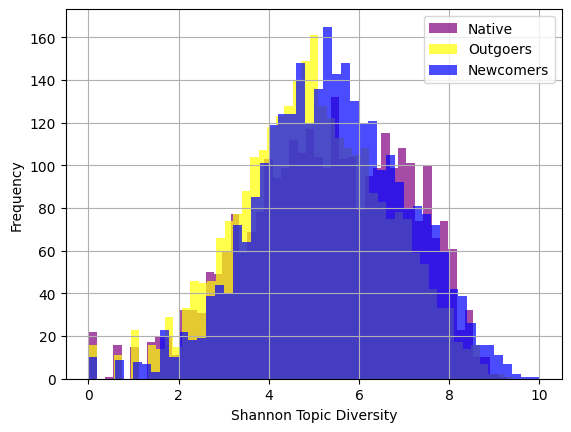

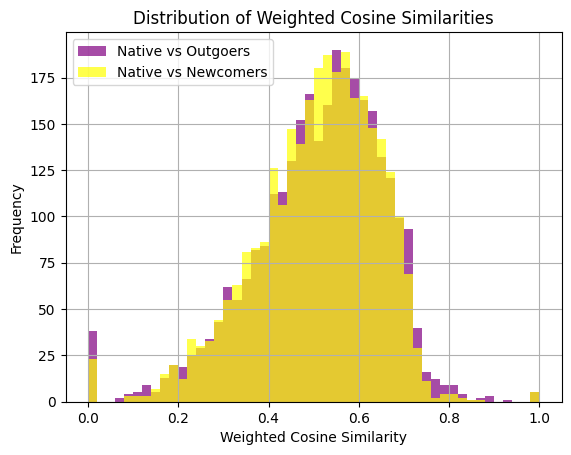

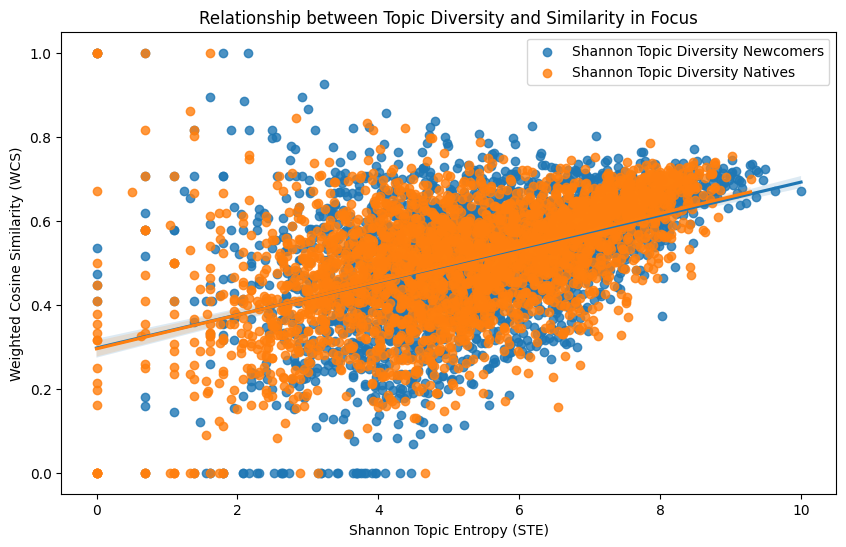

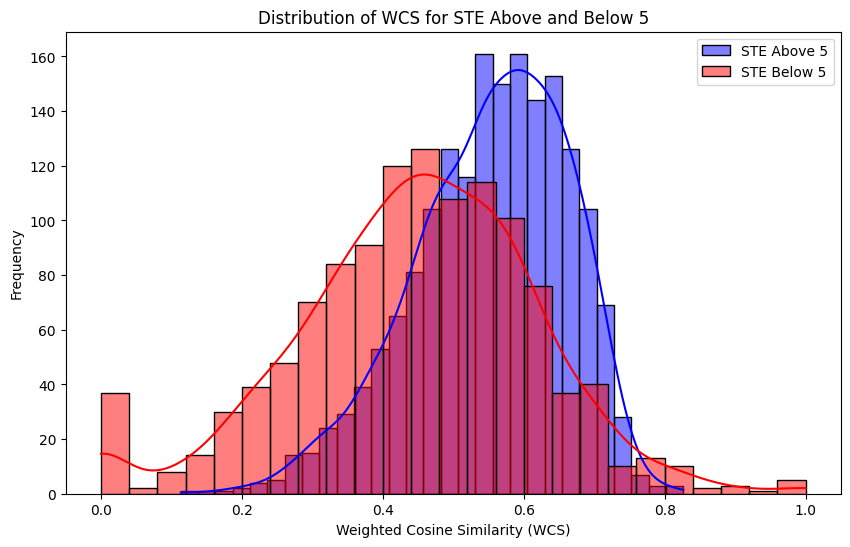

In [118]:
import matplotlib.pyplot as plt

# NATIVE | OUTGOERS
values0 = [item['shannon_nat'] for item in shannon_diversity_nat.values()]
values1 = [item['shannon_out'] for item in shannon_diversity_out.values()]
values2 = [item['shannon_new'] for item in shannon_diversity_new.values()]

# Plot histograms with labels
plt.hist(values0, bins=50, color='purple', alpha=0.7, label='Native')
plt.hist(values1, bins=50, color='yellow', alpha=0.7, label='Outgoers')
plt.hist(values2, bins=50, color='blue', alpha=0.7, label='Newcomers')
plt.legend()
plt.title('')
plt.xlabel('Shannon Topic Diversity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# %%%%%%%%%%%%%%%%%%%%%%%%%%% #

# Extracting values from the dictionary
import matplotlib.pyplot as plt

# NATIVE | OUTGOERS
values0 = [item['wcs_nat_out'] for item in weighted_cosine_similarities_nat_out.values()]
values1 = [item['wcs_nat_new'] for item in weighted_cosine_similarities_nat_new.values()]

plt.hist(values0, bins=50, color='purple', alpha=0.7, label='Native vs Outgoers')
plt.hist(values1, bins=50, color='yellow', alpha=0.7, label='Native vs Newcomers')
plt.legend()
plt.title('Distribution of Weighted Cosine Similarities')
plt.xlabel('Weighted Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# %%%%%%%%%%%%%%%%%%%%%%%%%%% #

import matplotlib.pyplot as plt
import seaborn as sns

common_institutions0 = set(shannon_diversity_new.keys()).intersection(set(weighted_cosine_similarities_nat_out.keys()))
common_institutions1 = set(shannon_diversity_nat.keys()).intersection(set(weighted_cosine_similarities_nat_new.keys()))

nte_values0 = [shannon_diversity_new[inst]['shannon_new'] for inst in common_institutions0]
wcs_values0 = [weighted_cosine_similarities_nat_out[inst]['wcs_nat_out'] for inst in common_institutions0]

nte_values1 = [shannon_diversity_nat[inst]['shannon_nat'] for inst in common_institutions1]
wcs_values1 = [weighted_cosine_similarities_nat_new[inst]['wcs_nat_new'] for inst in common_institutions1]

plt.figure(figsize=(10, 6))
sns.regplot(x=nte_values0, y=wcs_values0, label='Shannon Topic Diversity Newcomers')
sns.regplot(x=nte_values1, y=wcs_values1, label='Shannon Topic Diversity Natives')
plt.legend()
plt.xlabel('Shannon Topic Entropy (STE)')
plt.ylabel('Weighted Cosine Similarity (WCS)')
plt.title('Relationship between Topic Diversity and Similarity in Focus')
plt.show()

# %%%%%%%%%%%%%%%%%%%%%%%%%%% #

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the threshold value for Shannon Topic Entropy (STE)
ste_threshold = 5

high_wcs_list = []
low_wcs_list = []


for i, inst in enumerate(common_institutions0):
    if i < len(nte_values0):
        ste_value = nte_values0[i]
        wcs_value = wcs_values0[i]

        # Check if STE is above 5
        if ste_value > ste_threshold:
            high_wcs_list.append(wcs_value)
        # Check if STE is below 5
        else:
            low_wcs_list.append(wcs_value)

plt.figure(figsize=(10, 6))
sns.histplot(high_wcs_list, color="blue", label="STE Above 5", kde=True)
sns.histplot(low_wcs_list, color="red", label="STE Below 5", kde=True)
plt.xlabel('Weighted Cosine Similarity (WCS)')
plt.ylabel('Frequency')
plt.title('Distribution of WCS for STE Above and Below 5')
plt.legend()
plt.show()


###  Diversity vs. Alignment